# Learning

In [1]:
# Directory navigation
import os

# Data handling
import numpy as np
from enum import Enum

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning
import lightgbm as lgbm
import joblib
from sklearn import metrics, preprocessing

# EO-specific imports
from eolearn.core import EOPatch, EOTask, LinearWorkflow
from eolearn.core import LoadTask, SaveTask, FeatureType, OverwritePermission, EOExecutor

In [2]:
DATA_FOLDER = 'data'
PATCH_FOLDER = os.path.join(DATA_FOLDER, 'lcc_out_eopatches')
LOGS_FOLDER = os.path.join(DATA_FOLDER, 'logs')

## 1. Training

After the lengthy data preparation, we can finally start training a classifier.

Let's load our data set:

In [3]:
DATA_SET_NAME = 'lcc_data_set.npz'

tmp = np.load(os.path.join(DATA_FOLDER, DATA_SET_NAME))

Xt, yt, Xv, yv = tmp['Xt'], tmp['yt'], tmp['Xv'], tmp['yv']

### 1.1 Model set-up

Setting up a LightGBM model should be familiar due to its [scikit-learn API](https://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api).

As far as parameter configuration is concerned, you can consult the documentation...
- [Full list of parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html)
- [Parameter tuning guide](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

...or determine it via [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

In [4]:
params = {
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'bin_construct_sample_cnt': 200000,
    'class_weight': None,
    'feature_fraction': 0.9,
    'is_unbalance': True,
    'learning_rate': 0.1,
    'metric': 'multi_logloss',
    'min_sum_hessian_in_leaf': 0.001,
    'min_data_in_leaf': 20,
    'min_gain_to_split': 0.,
    'n_estimators': 128,
    'num_class': len(np.unique(yt)),
    'num_leaves': 32,
    'objective': 'multiclass',
    'random_state': 42,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbosity': 1
}

model = lgbm.LGBMClassifier(**params)

In [ ]:
# Note: The set of parameters above is only a subset. Feel free to tweak the parameter values
#       or supply additional parameters.

In [ ]:
# Note: Depending on the parameters and available processing power,
#       training the model might take a considerable amount of time.

In [ ]:
# Note: Since LightGBM uses scikit-learn's API,
#       you can easily switch to one of the classifiers provided by the latter.

Train the model:

In [5]:
%%time

model.fit(Xt, yt)

Wall time: 2min 16s


LGBMClassifier(bagging_fraction=0.8, bagging_freq=2,
               bin_construct_sample_cnt=200000, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', is_unbalance=True, lambda_l1=0.1,
               lambda_l2=0.1, learning_rate=0.1, max_depth=-1,
               metric='multi_logloss', min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=20,
               min_gain_to_split=0.0, min_split_gain=0.0,
               min_sum_hessian_in_leaf=0.001, n_estimators=128, n_jobs=-1,
               num_class=6, num_leaves=32, objective='multiclass',
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, ...)

Let's see how well it scores on the data, on which it was trained:

In [6]:
%%time

res = model.predict(Xt)

np.mean(res == yt)

Wall time: 7.96 s


0.9809325608864391

In [ ]:
# Note: Our training set consists of some 320,000 pixels. Would you consider the inference time to be fast or slow?

In [ ]:
# Note: If you wanted to process the probabilities before making a prediction, you could use "predict_proba" instead.

Quick validation:

In [7]:
res = model.predict(Xv)

np.mean(res == yv)

0.9296570342965703

In [ ]:
# Note: The non-negligible difference in overall accuracy is not that surprising;
#       decision tree-based algorithms can be notoriously prone to overfitting,
#       although this effect can be somewhat mitigated with different parameters.

We can get a bit more fancy by using metrics from `scikit-learn`:

In [8]:
print('Classification accuracy %.2f %%' % (100. * metrics.accuracy_score(yv, res)))
print('Classification F1-score %.2f %%' % (100. * metrics.f1_score(yv, res, average='weighted')))

Classification accuracy 92.97 %
Classification F1-score 93.01 %


The model can be saved and loaded through the use of `joblib`:

In [9]:
MODEL_NAME = 'my_lgbm_model.pkl'

model_path = os.path.join(DATA_FOLDER, MODEL_NAME)

joblib.dump(model, model_path)

['data\\my_lgbm_model.pkl']

In [10]:
MODEL_NAME = 'my_lgbm_model.pkl'

model_path = os.path.join(DATA_FOLDER, MODEL_NAME)

model = joblib.load(model_path)

In [ ]:
# Note: Try training and saving several models - you may find the comparison interesting.

## 2. Validation

While the numbers according to different metrics *are* indicative of performance, to better assess the model's behaviour and see what it is actually doing, we will need to go a bit deeper.

### 2.1 Scores

First of all, the scores may notably differ between the classes:

In [11]:
res = model.predict(Xv)

In [12]:
LULC_names = {
    0: 'Cultivated land',
    1: 'Forest',
    2: 'Grassland',
    3: 'Shrubland',
    4: 'Water',
    5: 'Artificial surface'
}

class_labels = list(LULC_names.keys())
class_names = list(LULC_names.values())

f1_scores = metrics.f1_score(yv, res, labels=class_labels, average=None)
recall = metrics.recall_score(yv, res, labels=class_labels, average=None)
precision = metrics.precision_score(yv, res, labels=class_labels, average=None) 

print('             Class              |  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulc_type in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} | {1:2.1f} |  {2:2.1f}  | {3:2.1f}'.format(lulc_type, 
                                                                         f1_scores[idx] * 100., 
                                                                         recall[idx] * 100., 
                                                                         precision[idx] * 100.))

             Class              |  F1  | Recall | Precision
         --------------------------------------------------
         * Cultivated land      | 86.9 |  87.1  | 86.8
         * Forest               | 97.6 |  99.4  | 96.0
         * Grassland            | 88.8 |  89.3  | 88.3
         * Shrubland            | 50.7 |  56.1  | 46.2
         * Water                | 94.2 |  89.3  | 99.7
         * Artificial surface   | 96.2 |  94.7  | 97.6


### 2.2 Confusion matrix

Inter-class behaviour is customarily better represented with a confusion matrix, i.e. it may indicate between which classes the model can or cannot distinguish:

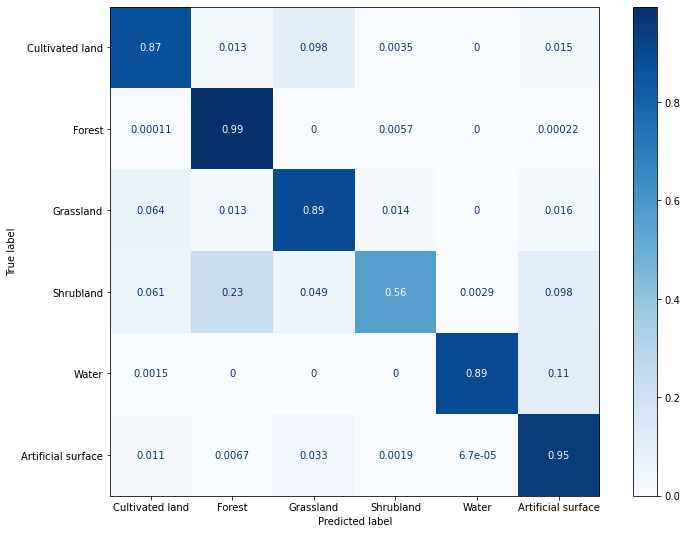

In [17]:
_, ax = plt.subplots(1,1,figsize=(12,9))

metrics.plot_confusion_matrix(model, Xv, yv, display_labels=class_names, cmap=plt.cm.Blues, normalize='true', ax=ax);

The model seems to mostly perform well, particularly if we consider that there may be some errors in the reference data (ground truth).

The exception is the "shrubland" class, which is the least represented in our training set:

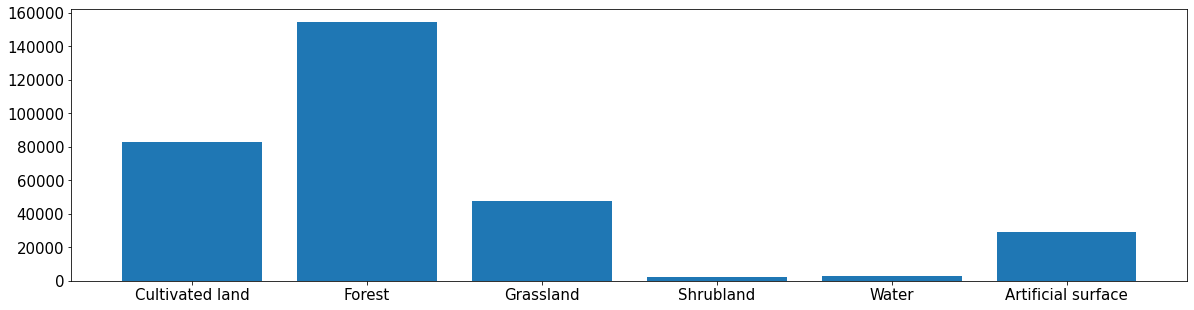

In [21]:
label_ids, label_counts = np.unique(yt, return_counts=True)

fig = plt.figure(figsize=(20, 5))

plt.bar(range(len(label_ids)), label_counts)

plt.xticks(range(len(label_ids)), [class_names[i] for i in label_ids], fontsize=15)
plt.yticks(fontsize=15);

It is actually more interesting that the "water" class is that easily distinguishable, despite also having only a few samples at our disposal. Obviously, some classes are more distinct than others.

### 2.3 ROC curve

The ROC (receiver operating characteristic) curve is defined in terms of true positive rate (TPR) and false positive rate (FPR) as the threshold that separates one class against the others is shifted.

Observing the ROC curve and calculating the area under it (AUC) can thus be useful in evaluating the model's separation of different classes.

In [22]:
class LULC(Enum):
    NO_DATA            = (0,  'No Data',            'white')
    CULTIVATED_LAND    = (1,  'Cultivated Land',    'xkcd:lime')
    FOREST             = (2,  'Forest',             'xkcd:darkgreen')
    GRASSLAND          = (3,  'Grassland',          'orange')
    SHRUBLAND          = (4,  'Shrubland',          'xkcd:tan')
    WATER              = (5,  'Water',              'xkcd:azure')
    WETLAND            = (6,  'Wetlands',           'xkcd:lightblue')
    TUNDRA             = (7,  'Tundra',             'xkcd:lavender')
    ARTIFICIAL_SURFACE = (8,  'Artificial Surface', 'crimson')
    BARELAND           = (9,  'Bareland',           'xkcd:beige')
    SNOW_AND_ICE       = (10, 'Snow and Ice',       'black')

    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])
lulc_norm = mpl.colors.BoundaryNorm(np.arange(-0.5, 11, 1), lulc_cmap.N)

new_to_ref = {0:1, 1:2, 2:3, 3:4, 4:5, 5:8}

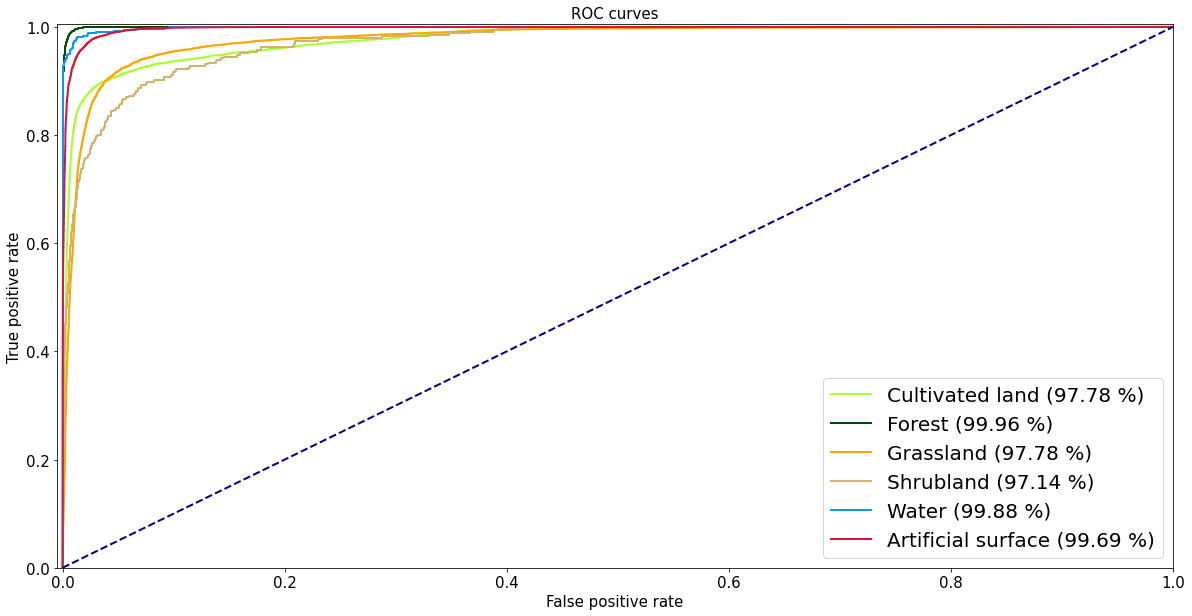

In [36]:
# Compute ROC and AUC
res_proba = model.predict_proba(Xv)
class_labels_bin = preprocessing.label_binarize(yv, classes=class_labels)

fpr = dict()
tpr = dict()
roc_auc = dict()

for idx, _ in enumerate(class_labels):
    fpr[idx], tpr[idx], _ = metrics.roc_curve(class_labels_bin[:, idx], res_proba[:, idx])
    roc_auc[idx] = metrics.auc(fpr[idx], tpr[idx]) 

# Plot
plt.figure(figsize=(20, 10))

for idx, label in enumerate(class_labels):
    plt.plot(fpr[idx], tpr[idx], color=lulc_cmap.colors[new_to_ref[label]],
             lw=2, label=class_names[label] + ' (%.2f %%)' % (roc_auc[idx] * 100.)
            )
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([-0.005, 1.])
plt.ylim([0., 1.005])

plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate', fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.title('ROC curves', fontsize=15)

plt.legend(loc='lower right', prop={'size': 20});

Note that shrubland's curve does not seem to reflect the poor scores seen before. That is because the poor scores reflected mistakes of shrubland for something else (mostly forest), i.e. misses or false negatives, which the ROC curve disregards. Evidently, one must be careful before jumping to conclusions based on one metric alone.

### 2.4 Interpretability

Decision trees can track the number of times that each feature was used to make a split when building a particular tree (or forest). This (or the cumulative information gain) can indicate which features are "more important" than others, at least to our model.

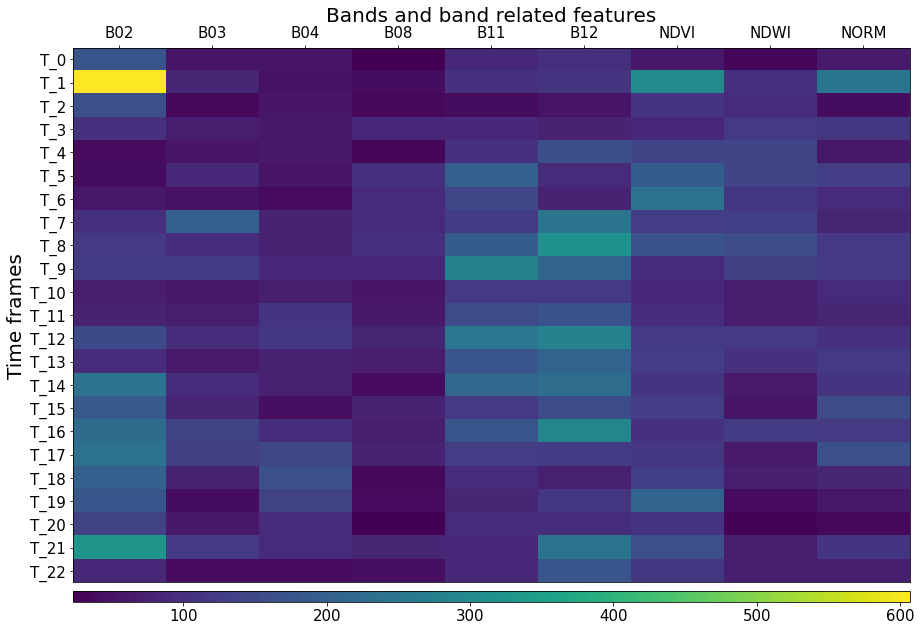

In [53]:
# Reshape features into a matrix of shape t x f
times = 23
features = 9
importances = model.feature_importances_.reshape(times, features)

feature_names = ['B02','B03','B04','B08','B11','B12','NDVI','NDWI','NORM']
time_names = ['T_%d' % i for i in range(times)]

# Plot
fig = plt.figure(figsize=(15, 15))
ax = plt.gca()

im = ax.imshow(importances, aspect=0.25)

plt.xticks(range(features), feature_names, fontsize=15)
plt.yticks(range(times), time_names, fontsize=15)
plt.xlabel('Bands and band related features', fontsize=20)
plt.ylabel('Time frames', fontsize=20)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# Number of splits
cb = fig.colorbar(im, ax=[ax], orientation='horizontal', pad=0.01, aspect=75)
cb.ax.tick_params(labelsize=15)

The most important features seem to be associated with the time frame `T_1`.

In [ ]:
# Note: When you decided which features to use through visual inspection and intuition,
#       did you expect this or a similar result?

Plotting the image for that time frame, we can see that it is covered in snow, implying that snow cover provides useful information in this scenario.

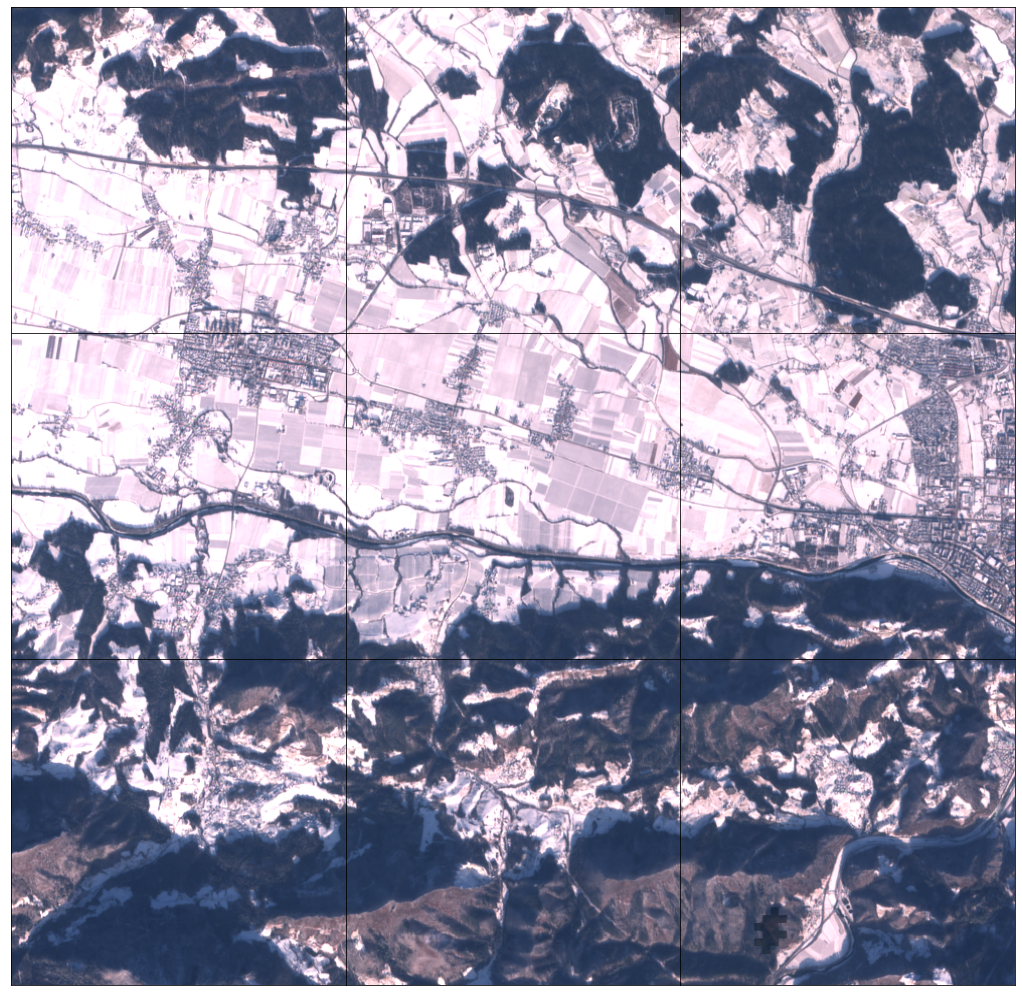

In [57]:
fig, axes = plt.subplots(3,3,figsize=(18, 18))

for ax, patch_name in zip(axes.flat, os.listdir(PATCH_FOLDER)):
    eopatch = EOPatch.load(os.path.join(PATCH_FOLDER, patch_name), lazy_loading=True)
    
    ax.imshow(np.clip(eopatch.data['FEATURES'][1][..., [2, 1, 0]] * 2.5, 0, 1))
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

By comparing histograms for band `B02` at the optimal time frame `T_1` and suboptimal time frame `T_10`, we can reach a similar conclusion:

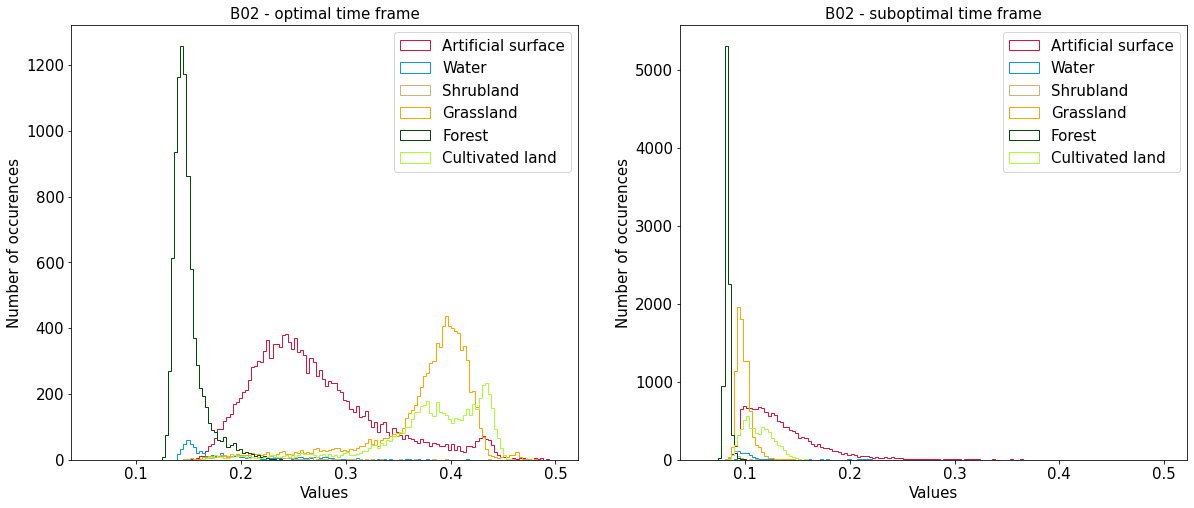

In [58]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 8))

# T_1
b2_t1 = Xv[:,1*9]

ax1.hist([b2_t1[yv == i] for i in class_labels], 150, (0.06, 0.5), histtype='step', label=class_names,
         color=[lulc_cmap.colors[new_to_ref[i]] for i in class_labels])

ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.set_xlabel('Values', fontsize=15)
ax1.set_ylabel('Number of occurences', fontsize=15)
ax1.set_title('B02 - optimal time frame', fontsize=15)
ax1.legend(loc='upper right', fontsize=15)

# T_10
b2_t10 = Xv[:,10*9]

ax2.hist([b2_t10[yv == i] for i in class_labels], 150, (0.06, 0.5), histtype='step', label=class_names,
         color=[lulc_cmap.colors[new_to_ref[i]] for i in class_labels])

ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)
ax2.set_xlabel('Values', fontsize=15)
ax2.set_ylabel('Number of occurences', fontsize=15)
ax2.set_title('B02 - suboptimal time frame', fontsize=15)
ax2.legend(loc='upper right', fontsize=15);

In [ ]:
# Note: What if you were to run the classifier on a case with no snow on time frame T1?
#       Due to the training data that it was given, the classifier has been taught to take it for granted,
#       so it is likely that it wouldn't work as expected.
#       Here you can see a problem that comes with a limited data set, as such a case is definitely realistic.

## 3. Segmentation

We can wrap our pixel-based classifier in a task that will use it to classify all of the pixels in a given patch. This way, we can produce a segmented map for an entire image.

In [74]:
class ClassificationTask(EOTask):
    """
    Runs the given classifier on a patch with the appropriate features.
    """
    
    def __init__(self, model, data_feature, out_feature):
        self.model = model
        self.data_feature = data_feature
        self.out_feature = out_feature
        
    def execute(self, eopatch):
        features = eopatch.data[self.data_feature]
        
        # Pixels into rows, features into columns
        t, w, h, f = features.shape
        features = np.moveaxis(features, 0, 2).reshape(w * h, t * f)
        
        # Run classifier
        res = self.model.predict(features)
        
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.out_feature, res.reshape(w, h, 1))
        
        return eopatch

classify = ClassificationTask(model, 'FEATURES', 'LULC_LGBM')

In [ ]:
# Note: If we wanted to run the classifier on a new case, we would need to preprocess it the same way beforehand.

Standard workflow and execution:

In [75]:
load = LoadTask(PATCH_FOLDER)

save = SaveTask(
    PATCH_FOLDER,
    features=[(FeatureType.MASK_TIMELESS, 'LULC_LGBM')],
    overwrite_permission=OverwritePermission.ADD_ONLY
)

workflow = LinearWorkflow(
    load,
    classify,
    save
)

execution_args = []

for patch_name in os.listdir(PATCH_FOLDER):
    execution_args.append(
        {
            load: {'eopatch_folder': patch_name},
            save: {'eopatch_folder': patch_name}
        }
    )

In [76]:
executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder=LOGS_FOLDER)

executor.run(workers=4, multiprocess=False)

executor.make_report()

C:\Users\jerne\Anaconda3\envs\eow\lib\site-packages\holoviews\operation\datashader.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Callable


In [ ]:
# Note: Since we reduced the size of the patches by only saving the necessary features,
#       you can probably use multiprocessing and a higher number of workers without major issues.

### 3.1 Visualisation

In [78]:
class ReferenceMapping:
    def __init__(self, labels, to_reference, to_new):
        self.labels = labels
        self.to_reference = np.vectorize(to_reference)
        self.to_new = np.vectorize(to_new)


labels = [1,2,3,4,5,8]

def to_reference(x):
    new_to_ref = {0:1, 1:2, 2:3, 3:4, 4:5, 5:8}
    
    return new_to_ref[x]

def to_new(x):
    ref_to_new = {1:0, 2:1, 3:2, 4:3, 5:4, 8:5}
    
    return ref_to_new[x]

mapping = ReferenceMapping(labels, to_reference, to_new)

What our model predicted...

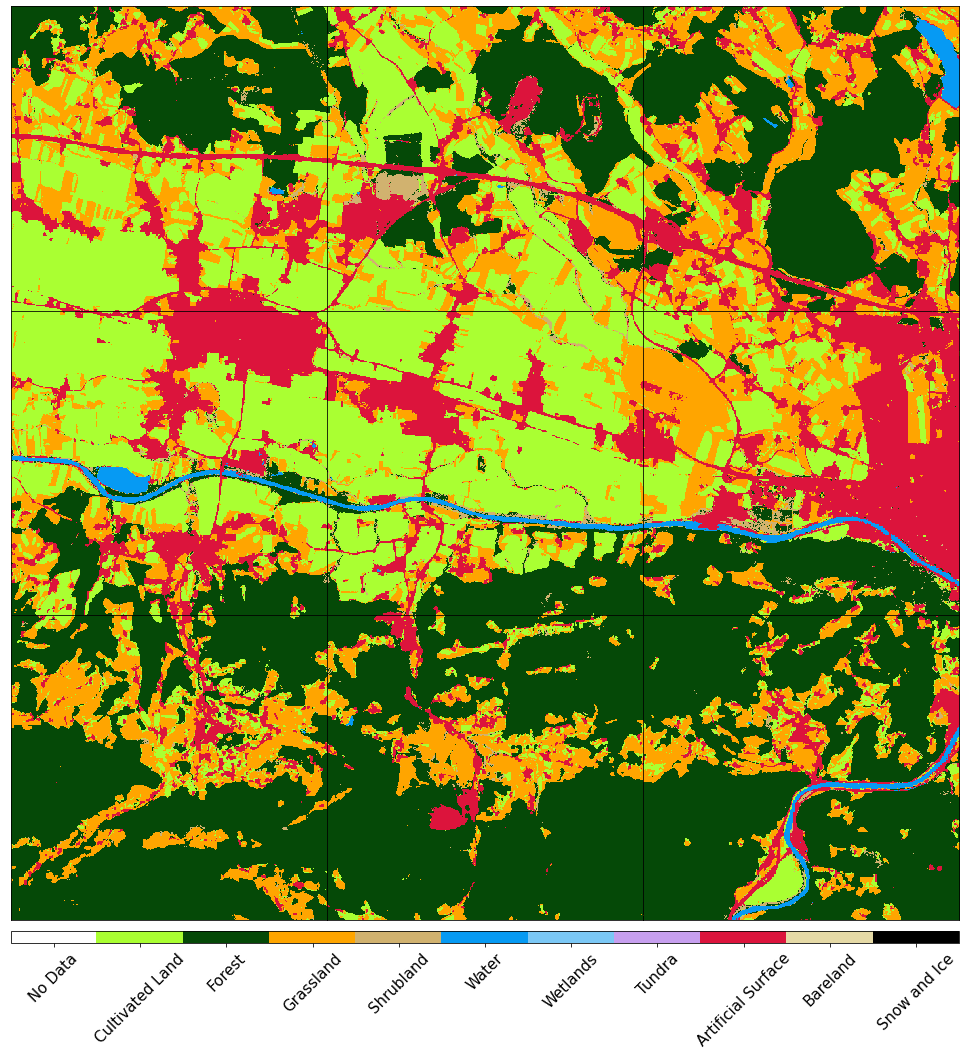

In [89]:
fig, axes = plt.subplots(3,3,figsize=(17, 20))

for ax, patch_name in zip(axes.flat, os.listdir(PATCH_FOLDER)):
    eopatch = EOPatch.load(os.path.join(PATCH_FOLDER, patch_name), lazy_loading=True)
    
    lulc_lgbm = mapping.to_reference(eopatch.mask_timeless['LULC_LGBM'][...,0])
    
    # Specify 'nearest' interpolation to prevent plotting artifacts
    im = ax.imshow(lulc_lgbm, interpolation='nearest', cmap=lulc_cmap, norm=lulc_norm)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
    
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.flat, orientation='horizontal', pad=0.01, aspect=75)
cb.ax.tick_params(labelsize=15) 
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.class_name for entry in LULC], rotation=45, fontsize=15);

...versus the reference data:

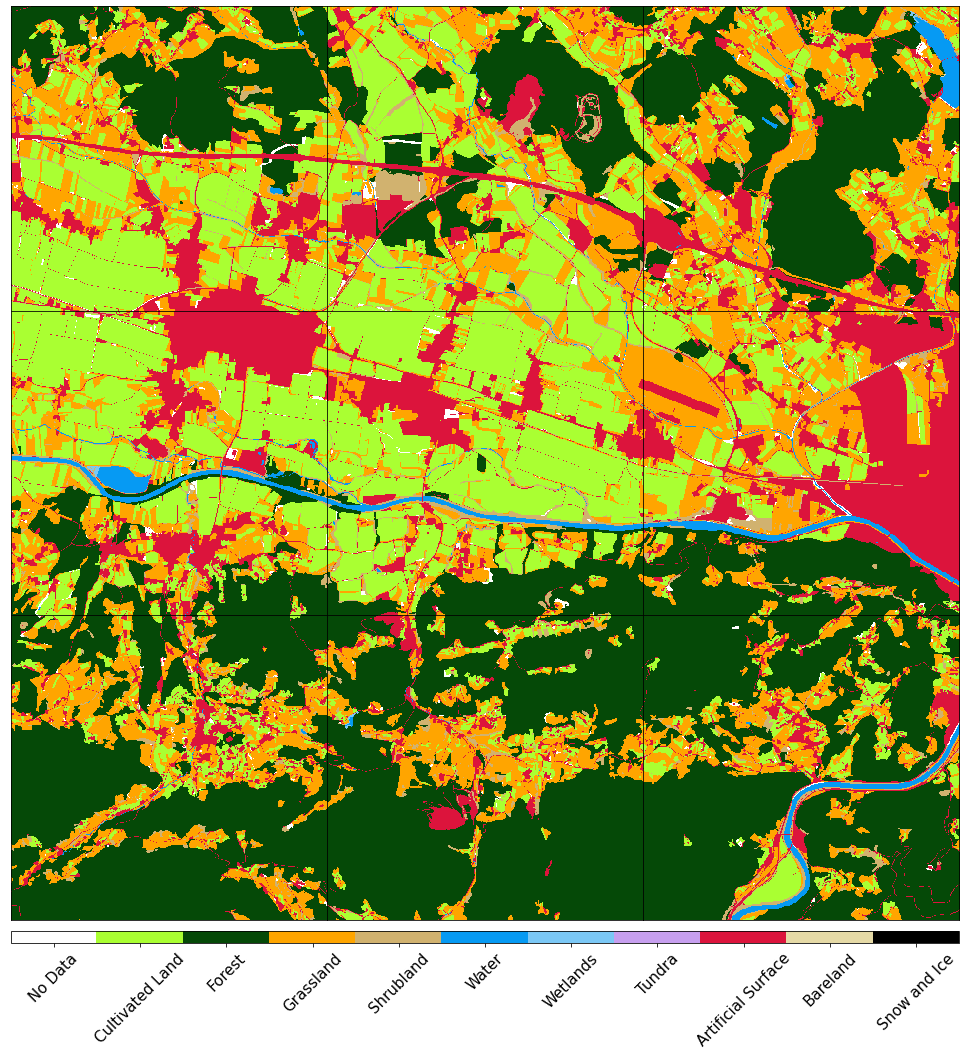

In [88]:
fig, axes = plt.subplots(3,3,figsize=(17, 20))

for ax, patch_name in zip(axes.flat, os.listdir(PATCH_FOLDER)):
    eopatch = EOPatch.load(os.path.join(PATCH_FOLDER, patch_name), lazy_loading=True)
    
    lulc_ref = eopatch.mask_timeless['LULC'][...,0]
    
    # Specify 'nearest' interpolation to prevent plotting artifacts
    im = ax.imshow(lulc_ref, interpolation='nearest', cmap=lulc_cmap, norm=lulc_norm)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
    
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axes.flat, orientation='horizontal', pad=0.01, aspect=75)
cb.ax.tick_params(labelsize=15) 
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.class_name for entry in LULC], rotation=45, fontsize=15);

In [ ]:
# Note: We didn't include patch 5 in our training data, so we can expect there to be the most noticeable inconsistencies.

### 3.2 Discrepancy

Taking a closer look, we can observe that the differences mostly lie on the border between different structures or belong to thing structures, such as roads.

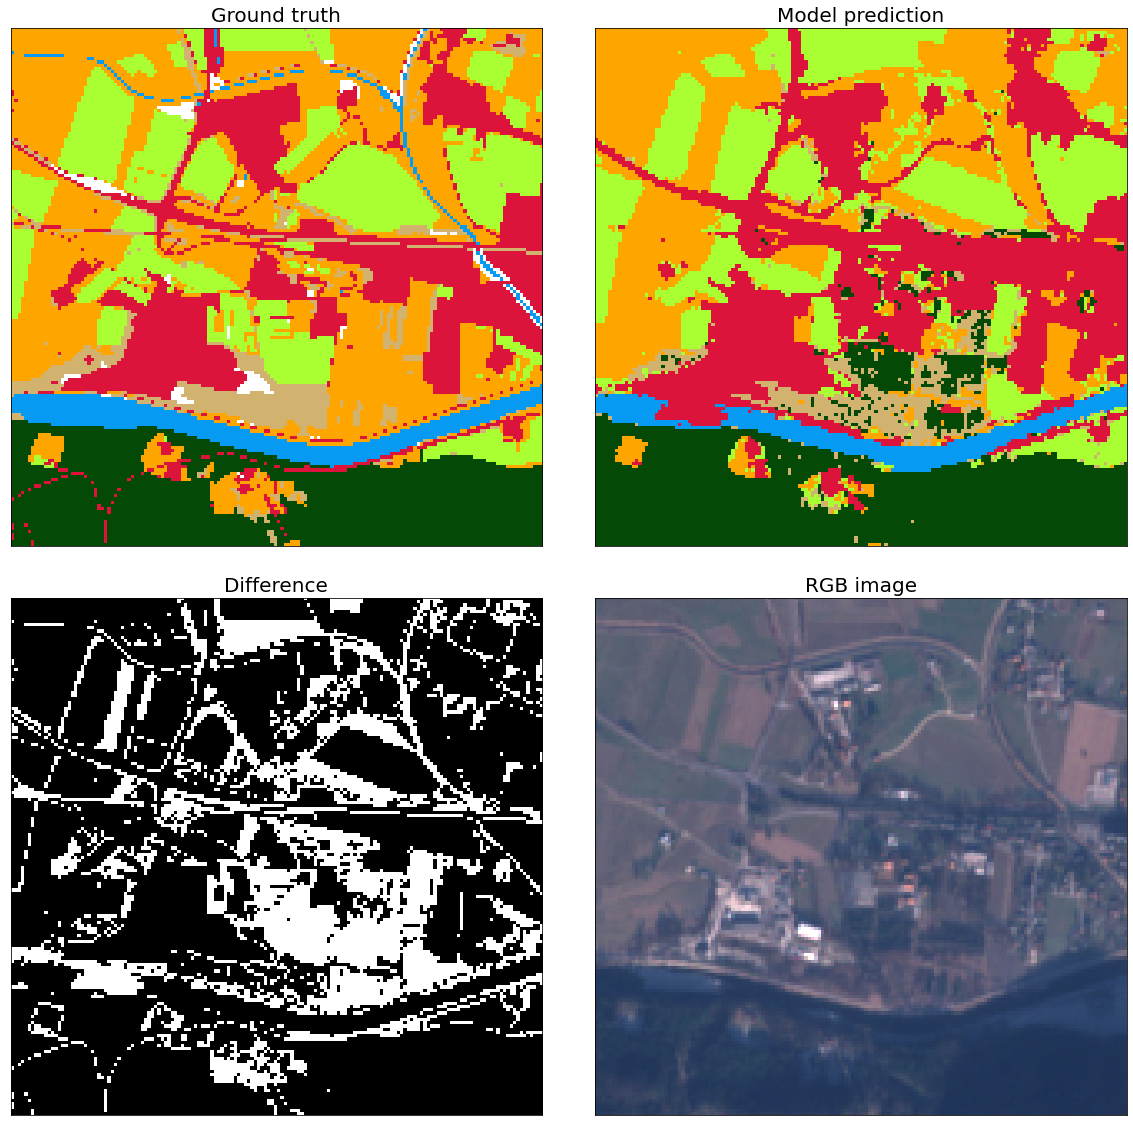

In [93]:
eopatch = EOPatch.load(os.path.join(PATCH_FOLDER, 'eopatch_5'), lazy_loading=True)

lulc_ref = eopatch.mask_timeless['LULC'][...,0]
lulc_lgbm = mapping.to_reference(eopatch.mask_timeless['LULC_LGBM'][...,0])

# Plot
fig, axes = plt.subplots(2,2,figsize=(20, 20))

# Section of area to observe
w_min, w_max = 120, 280
h_min, h_max = 40, 200

# Reference / ground truth
axes[0,0].imshow(lulc_ref[w_min:w_max, h_min:h_max], interpolation='nearest', cmap=lulc_cmap, norm=lulc_norm)
axes[0,0].set_title('Ground truth', fontsize=20)

# Model prediction
axes[0,1].imshow(lulc_lgbm[w_min:w_max, h_min:h_max], interpolation='nearest', cmap=lulc_cmap, norm=lulc_norm)
axes[0,1].set_title('Model prediction', fontsize=20)

# Difference
diff = np.where(lulc_ref != 0, lulc_ref, lulc_lgbm) != lulc_lgbm
axes[1,0].imshow(diff[w_min:w_max, h_min:h_max], cmap='gray')
axes[1,0].set_title('Difference', fontsize=20)

# True colour image
rgb = np.clip(eopatch.data['FEATURES'][0][..., [2, 1, 0]] * 3.5, 0, 1)
axes[1,1].imshow(rgb[w_min:w_max, h_min:h_max])
axes[1,1].set_title('RGB image', fontsize=20)

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')

fig.subplots_adjust(wspace=0.1, hspace=0.1)

### 3.3 End goal

After training and validating our model, we would use it to process the entire area of interest, as demonstrated in one of Sinergise's [blog posts](https://medium.com/sentinel-hub/land-cover-monitoring-system-84406e3019ae):

<img src="images/lcms_azer.png">

## 4. Final remarks

Hopefully, by running this example (and perhaps experimenting with it), you got a feel for how things look in this particular field. If you've enjoyed the workshop and are potentially interested in this line of work, feel free to contact the [EO Research team](mailto:eoresearch@sinergise.com) at Sinergise.